# Language Translation (german to english)

In [1]:
from io import open
import matplotlib.pyplot as plt
import re
import random
import unicodedata
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

# We are defaulting to CPU, but you may want to compare CPU vs GPU performance
# device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu" # Use cpu since this dataset is too small to take advantage of the GPU

In [2]:
SOS_token = 0 # Start of sentence
EOS_token = 1 # End of sentence

class LanguageTranslation:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        # Add new words or increase count of existing words
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

# Turn Unicode characters to ASCII, make everything lowercase, and trim most punctuation.
def normalizeString(s):    
    s = s.lower().strip()    
    s = ''.join(
        char for char in unicodedata.normalize('NFD', s)
        if unicodedata.category(char) != 'Mn')    
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)    
    return s

# Read the language file, split into lines, then split lines into pairs and normalize
def readLanguageFile(lang1, lang2, reverse=False):    
    print("Reading lines...")
    lines = open('../../inputs/%s-%s.txt' % (lang1, lang2), encoding='utf-8'). \
                  read().strip().split('\n')
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = LanguageTranslation(lang2)
        output_lang = LanguageTranslation(lang1)
    else:
        input_lang = LanguageTranslation(lang1)
        output_lang = LanguageTranslation(lang2)
    return input_lang, output_lang, pairs

# Preparing Training Data
# To train, for each pair we will need an input tensor (indexes of the words in the input sentence) and target tensor (indexes of the words in the target sentence)
# While creating these vectors we will append the EOS token to both sequences.
def tensorFromSentence(lang, sentence):
    indexes = [lang.word2index[word] for word in sentence.split(' ')]
    indexes.append(EOS_token)    
    return torch.tensor(indexes, dtype=torch.long).view(-1, 1).to(device)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])    
    return (input_tensor, target_tensor)

# Since there are a lot of example sentences and we want to train something quickly, we’ll trim the data set to only relatively short and simple sentences
# Maximum length is 10 words (that includes ending punctuation) and we’re filtering to sentences that translate to the form “I am” or “He is” etc. (accounting for apostrophes replaced earlier).
MAX_LENGTH = 10 
eng_prefixes = ("i am ", "i m ",
                "he is", "he s ",
                "she is", "she s ",
                "you are", "you re ",
                "we are", "we re ",
                "they are", "they re ")

# Filter down pairs to reduce training time
def filterPairs(pairs):
    return [p for p in pairs 
            if 
            len(p[0].split(' ')) < MAX_LENGTH and 
            len(p[1].split(' ')) < MAX_LENGTH and 
            p[1].startswith(eng_prefixes)]
   
# Read the data file, split into lines, then split lines into pairs and normalize
# The file is English → German, to translate German → English add reverse flag to reverse the pairs
input_lang, output_lang, pairs = readLanguageFile('eng', 'deu', True)
print("Read %s sentence pairs" % len(pairs))  
# Filter down pairs to reduce training time  
pairs = filterPairs(pairs)
print("Trimmed to %s sentence pairs" % len(pairs))    
# Make word lists from sentences in pairs
for pair in pairs:
    input_lang.addSentence(pair[0])
    output_lang.addSentence(pair[1])        
print("Counted words:")
print(input_lang.name, input_lang.n_words)
print(output_lang.name, output_lang.n_words)    

# print a random English to German translated string
print(f"\nExample of single English to German language pair: {random.choice(pairs)}")

Reading lines...
Read 176692 sentence pairs
Trimmed to 9678 sentence pairs
Counted words:
deu 4494
eng 2913

Example of single English to German language pair: ['du bist unglaublich !', 'you re unbelievable .']


In [3]:
# A Sequence to Sequence network, or seq2seq network, or Encoder Decoder network, is a model consisting of two RNNs called the encoder and decoder
# The encoder reads an input sequence and outputs a single vector, and the decoder reads that vector to produce an output sequence
class EncoderRNN(nn.Module):    
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()        
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)        
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):        
        # [1, hidden_size] -> [1, 1, hidden_size]
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded        
        output, hidden = self.gru(output, hidden)        
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)

# At every step of decoding, the decoder is given an input token and hidden state
# The initial input token is the start-of-string SOS token, and the first hidden state is the context vector (the encoder’s last hidden state)
class DecoderRNN(nn.Module):    
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()        
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)      
        self.gru = nn.GRU(hidden_size, hidden_size)        
        self.out = nn.Linear(hidden_size, output_size)        
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)     
        output, hidden = self.gru(output, hidden)        
        # [1, 1, hidden_size] -> [1, hidden_size]
        output = self.softmax(self.out(output[0]))        
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)

Epoch 1000 (10%), Loss: 27.36
Epoch 2000 (20%), Loss: 26.43
Epoch 3000 (30%), Loss: 25.72
Epoch 4000 (40%), Loss: 25.26
Epoch 5000 (50%), Loss: 24.93
Epoch 6000 (60%), Loss: 24.53
Epoch 7000 (70%), Loss: 24.22
Epoch 8000 (80%), Loss: 23.93
Epoch 9000 (90%), Loss: 23.72
Epoch 10000 (100%), Loss: 23.58


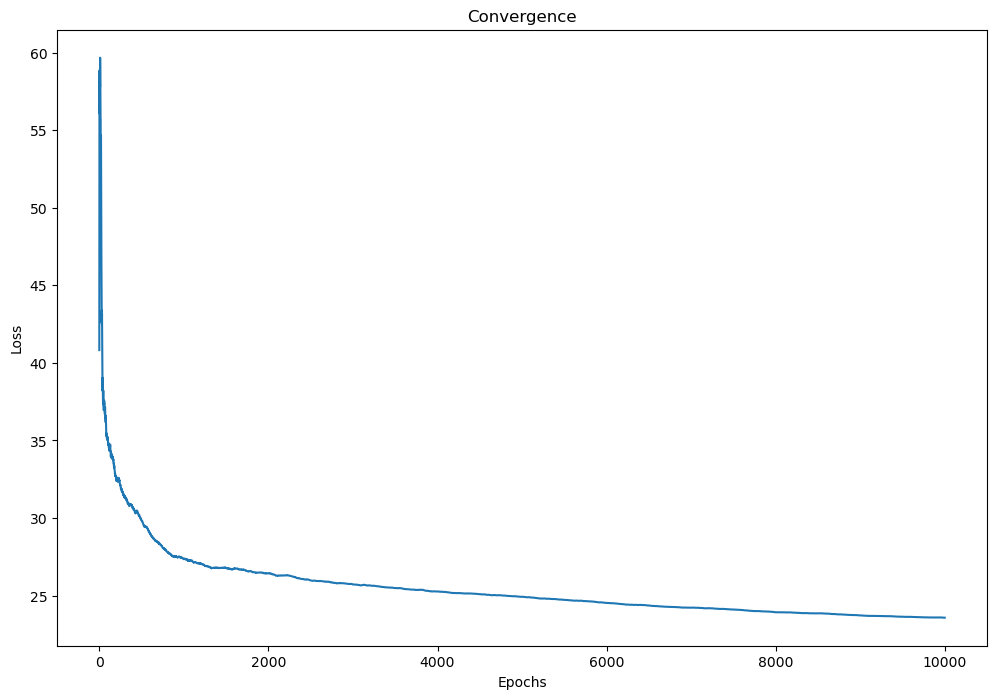

In [4]:
# Start empty losses array for plotting
input_size = input_lang.n_words
hidden_size = 64
output_size = output_lang.n_words
# Initialize models, criterion, and optimizers
model_encoder = EncoderRNN(input_size, hidden_size).to(device)
model_decoder = DecoderRNN(hidden_size, output_size).to(device)
criterion = nn.NLLLoss()
optimizer_encoder = optim.SGD(model_encoder.parameters(), lr=0.01)
optimizer_decoder = optim.SGD(model_decoder.parameters(), lr=0.01)

# Train many randomly choosen pairs to build the overall model
def train(model_encoder, model_decoder, criterion, optimizer_encoder, optimizer_decoder, num_epochs, teacher_forcing_ratio):
    # To train we run the input sentence through the encoder, and keep track of every output and the latest hidden state
    # Then the decoder is given the SOS token as its first input, and the last hidden state of the encoder as its first hidden state.
    # Teacher forcing is the concept of using the real target outputs as each next input, instead of using the decoder’s guess as the next input.
    training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(num_epochs)]
    total_loss = 0
    plot_losses = []
    model_encoder.train() # Put the model in "training mode", which turns on dropout and batch normalization
    model_decoder.train() # Put the model in "training mode", which turns on dropout and batch normalization
    for epoch in range(1, num_epochs+1):    
        training_pair = training_pairs[epoch - 1]
        input_tensor = training_pair[0]
        input_length = input_tensor.size(0)
        target_tensor = training_pair[1]
        target_length = target_tensor.size(0)
        encoder_hidden = model_encoder.initHidden().to(device)
        loss = 0
        for ei in range(input_length):
            encoder_output, encoder_hidden = model_encoder(input_tensor[ei], encoder_hidden)
        decoder_input = torch.tensor([[SOS_token]])
        decoder_hidden = encoder_hidden
        use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
        if use_teacher_forcing:       
            for di in range(target_length):
                decoder_output, decoder_hidden = model_decoder(decoder_input, decoder_hidden)            
                loss += criterion(decoder_output, target_tensor[di]).to(device)
                decoder_input = target_tensor[di] # Use acutal output as next input
        else:        
            for di in range(target_length):
                decoder_output, decoder_hidden = model_decoder(decoder_input, decoder_hidden)            
                topv, topi = decoder_output.topk(1) # Use predicted output as next input
                decoder_input = topi.squeeze().detach()  
                loss += criterion(decoder_output, target_tensor[di])
                if decoder_input.item() == EOS_token:
                    break
        optimizer_encoder.zero_grad()
        optimizer_decoder.zero_grad()
        loss.backward()
        optimizer_encoder.step()
        optimizer_decoder.step()
        total_loss += loss.item()
        if epoch % 1000 == 0:  # Show progress every 1000 passes
            percentComplete = epoch/num_epochs*100
            print(f'Epoch {epoch} ({percentComplete:.0f}%), Loss: {total_loss/epoch:.2f}')
        plot_losses.append(total_loss/epoch)
    return plot_losses

# Train the model
plot_losses = train(model_encoder, model_decoder, criterion, optimizer_encoder, optimizer_decoder, num_epochs = 10000, teacher_forcing_ratio = 0.5)
fig, ax = plt.subplots(figsize=(12, 8))
plt.title("Convergence")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(plot_losses)

In [5]:
# KEY: > input = target < output
# There are no targets so we simply feed the decoder’s predictions back to itself for each step
# Every time it predicts a word we add it to the output string, and if it predicts the EOS token we stop there. 
def evaluate(encoder, decoder, sentence):    
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size(0)        
        encoder_hidden = encoder.initHidden()
        encoder.eval() # Put the model in "evaluation mode", this turns off dropout and batch normalization.
        decoder.eval() # Put the model in "evaluation mode", this turns off dropout and batch normalization.
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        decoder_input = torch.tensor([[SOS_token]])  
        decoder_hidden = encoder_hidden
        decoded_words = []
        for di in range(MAX_LENGTH):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)            
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break                
            else:
                decoded_words.append(output_lang.index2word[topi.item()])
            decoder_input = topi.squeeze().detach()
        return decoded_words

# We can evaluate random sentences from the training set and print out the input, target, and output to make some subjective quality judgements:
# To get more accurate results, don't filterPairs(), and don't use teacher_forcing, but those will increase model training time
#        x minutes vs y minutes on Mac M1 Max
for i in range(10):        
        pair = random.choice(pairs)        
        print('>', pair[0])
        print('=', pair[1])        
        output_words = evaluate(model_encoder, model_decoder, pair[0])
        output_sentence = ' '.join(output_words)        
        print('<', output_sentence)
        print('')

> er macht nicht mehr lange .
= he s on his last legs .
< he s not to . . . <EOS>

> er ist senil geworden .
= he s gone senile .
< he s a . . . <EOS>

> wir haben angst .
= we re afraid .
< we re not . . . <EOS>

> er greift hart gegen das verbrechen durch .
= he s tough on crime .
< he is a to of the . . <EOS>

> ich freue mich auf den nachsten sommer .
= i m looking forward to next summer .
< i m not to to you . . . <EOS>

> die sind nicht hier .
= they re not here .
< you are not to . . . <EOS>

> ich bin jetzt in boston stationiert .
= i m based in boston now .
< i m not to . . . . <EOS>

> ich bin immer vorsichtig .
= i m always careful .
< i m not . . . <EOS>

> sie belieben wohl zu scherzen !
= you re joking !
< you are not to . . . <EOS>

> ich werde einen arzt suchen .
= i m going to go find a doctor .
< i m not to to . . . . <EOS>



In [6]:
# Use model
input_sentence = 'es tut mir sehr leid' #Re-run for 'es geht mir gut'
output_words = evaluate(model_encoder, model_decoder, input_sentence)
print('input =', input_sentence)
print('output =', ' '.join(output_words))

input = es tut mir sehr leid
output = i m not to of you . . . <EOS>
